In [1]:
from matplotlib.pyplot import imread,imshow
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.utils import shuffle
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import glob
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist

2021-10-17 12:40:09.162192: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing:

**Split output (y) as the label of the data, and input (x) as the features (pixels)**

**X test also, but note X_test has no labeled values**

In [3]:
X_train = (train.iloc[:,1:].values).astype('float32')
y_train = train.iloc[:,0].values.astype('int32')

X_test = test.values.astype('float32')

****Reshape x to get the image shape, (m, nw, nh, nc), nc = 1 as it's black and white (if colored nc = 3)****

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
print(X_train.shape)

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


**Rescale X , divided over 255, the maximum number of any pixel**

In [5]:
X_train /= 255
X_test /= 255

**Convert y train to one hot code, to be used in training**

**One-time-run code, don't run it again**

In [6]:
y_train = to_categorical(y_train, 10)
# y_train

# ****Creating Model****

In [7]:
model = Sequential([
    
    Conv2D(filters=64, kernel_size=7, strides=1, activation='relu', input_shape=(28,28,1)), # 22 x 22 x 64
    MaxPooling2D(pool_size=2, strides=2), # 11 x 11 x 64
    BatchNormalization(),
    Conv2D(128, (5,5), activation='relu'), # 7 x 7 x 128
    MaxPooling2D(pool_size=2), #as 7 isn't divisble by 2, we don't choose stride=2 for pooling instead default= 1
    # 3 x 3 x 128
    Conv2D(256, (3,3), activation='relu'), # 1 x 1 x 256
    Flatten(), # 256
    Dense(1000, activation='relu'), # 1000
    Dense(10, activation='softmax') #for multiclassification we use softmax
    
])

2021-10-17 12:40:18.649048: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-17 12:40:18.652592: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-17 12:40:18.703588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 12:40:18.704265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-17 12:40:18.704334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-17 12:40:18.732241: I tensorflow/stream_executor/platform/def

# Compiling the model:
1. loss done by using categorical loss function as the problem is categorical (numbers 0 - 9)
2. We always use adam as it's the best optimizer shares the characteristics of RMSprop and Momentun
3. We can choose any metric to evaluate our model, i always choose accuracy

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 22, 22, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

# Model Training:

In [10]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [11]:
history = model.fit(X_train, y_train, batch_size=100, epochs=20, validation_split=0.1)

2021-10-17 12:40:21.099710: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-17 12:40:21.110973: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000189999 Hz


Epoch 1/20


2021-10-17 12:40:21.669678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-17 12:40:22.454125: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-17 12:40:22.465726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


378/378 [==============================] - 9s 6ms/step - loss: 0.3118 - accuracy: 0.9015 - val_loss: 0.2567 - val_accuracy: 0.9729
Epoch 2/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0546 - accuracy: 0.9830 - val_loss: 0.0526 - val_accuracy: 0.9845
Epoch 3/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0308 - accuracy: 0.9898 - val_loss: 0.0489 - val_accuracy: 0.9864
Epoch 4/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 0.0521 - val_accuracy: 0.9850
Epoch 5/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.0372 - val_accuracy: 0.9900
Epoch 6/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0385 - val_accuracy: 0.9890
Epoch 7/20
378/378 [==============================] - 2s 5ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0402 - val_accuracy: 0.9890
Epoch 8/20
378/37

In [12]:
history = pd.DataFrame(history.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.143306,0.955556,0.256658,0.972857
1,0.053264,0.983889,0.052613,0.984524
2,0.034458,0.989153,0.048927,0.986429
3,0.025693,0.991561,0.052126,0.985000
4,0.023059,0.992936,0.037168,0.990000
5,0.022529,0.992646,0.038456,0.989048
6,0.017154,0.994709,0.040157,0.989048
7,0.015464,0.995423,0.062984,0.984762
8,0.015733,0.995053,0.027962,0.992143
9,0.011946,0.996693,0.044514,0.986667


# Visualize the training examples:

Predicted Value  :  3


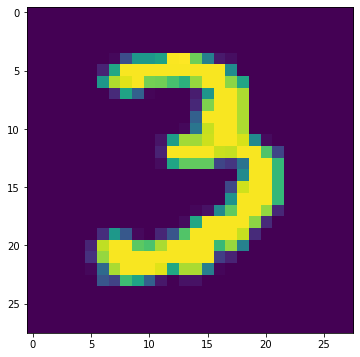

In [13]:
fig = plt.figure(figsize=(6,6))
num = 9
plt.imshow(X_train[num])
print("Predicted Value  : ", np.argmax(y_train[num]))

# Predict and Submit:

In [14]:
predictions = model.predict(X_test)

In [15]:
predictions.shape

(28000, 10)

In [16]:
pred = np.argmax(predictions, axis=1)
pred

array([2, 0, 9, ..., 3, 9, 2])

Predicted Value  :  6


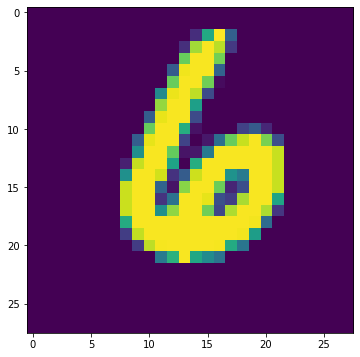

In [17]:
fig = plt.figure(figsize=(6,6))
num = 50
plt.imshow(X_test[num])
print("Predicted Value  : ", pred[num])

In [18]:
df_submission = pd.DataFrame()
ID = [i for i in range(1, pred.shape[0]+1)]

df_submission['Image ID'] = ID
df_submission['Label'] = pred

df_submission.to_csv("submission.csv", index=False)